In [1]:
%pylab inline
import pandas as pd
import theano
theano.config.floatX = 'float64'
import pymc3 as pm

import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


In [2]:
sample_info = pd.read_csv('~/Google Drive/Research Projects/Finished/LysisBuffers/data_exchange/lysis-buffer-samples.csv', index_col=0)
tpm = pd.read_csv('~/Google Drive/Research Projects/Finished/LysisBuffers/data_exchange/lysis-buffer-tpm.csv', index_col=0)
logexp = np.log10(tpm + 1)
logexp = logexp[sample_info.index]

In [3]:
import patsy

In [4]:
Y = patsy.dmatrix('np.log(num_genes) + np.log(num_mapped) + LB_type', sample_info, return_type='dataframe')

In [42]:
partial_logexp = logexp.sample(100, axis=0)

In [43]:
long_data = pd.melt(partial_logexp.T.join(Y),
                    id_vars=Y.columns.tolist())

covars = long_data.drop(['variable', 'value'], 1)
genes = long_data.variable.astype('category')
y = long_data.value.values

N = y.shape[0]
P = covars.shape[1]
G = genes.cat.categories.shape[0]
data = {
    'N': N,
    'P': P,
    'G': G,
    'x': covars.values,
    'y': y,
    'gene': genes.cat.codes.values
}

In [44]:
np.zeros((1,P))

array([[ 0.,  0.,  0.,  0.]])

In [45]:
x_t = tt.matrix()
x_t.tag.test_value = np.zeros((1, P))

y_t = tt.vector()
y_t.tag.test_value = np.zeros(1)

gene_t = tt.vector(dtype='int32')
gene_t.tag.test_value = np.zeros(1, dtype=int32)

minibatch_tensors = [x_t, y_t, gene_t]

In [46]:
with pm.Model() as model:
    sigma = pm.Lognormal('sigma', mu=0., sd=1.0, testval=1.0)
    alpha = pm.InverseGamma('alpha', alpha=2., beta=1., shape=(P,))
    w_list = []
    for p in range(data['P']):
        w_list.append(pm.Normal('w{}'.format(p), mu=0., sd=alpha[p] * sigma, shape=(G,)))
    
    w = tt.stack(w_list, axis=1)
    
    mu = tt.sum(w[gene_t] * x_t, axis=1)
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=y_t)

In [47]:
minibatch_RVs = [likelihood]

In [48]:
data['x'][[4, 3, 4, 3, 4]].shape

(5, 4)

In [49]:
data['x'].shape

(9600, 4)

In [50]:
def minibatch_gen(data):
    rng = np.random.RandomState(9)
    
    while True:
        ixs = rng.randint(len(data['x']), size=200)
        yield data['x'][ixs], data['y'][ixs], data['gene'][ixs]

In [51]:
minibatches = minibatch_gen(data)

In [52]:
means, sds, elbos = pm.variational.advi_minibatch(
    model=model, n=50000, minibatch_tensors=minibatch_tensors,
    minibatch_RVs=minibatch_RVs, minibatches=minibatches,
    total_size=len(data['x'])
)

Average ELBO = -3,462.12: 100%|████████████████████████████████████████████████| 50000/50000 [00:27<00:00, 1846.16it/s]
Finished minibatch ADVI: ELBO = -5,819.55


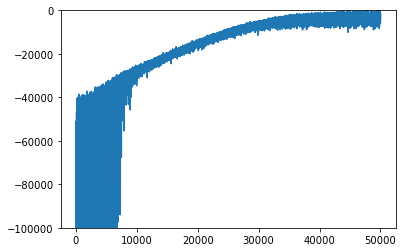

In [57]:
plt.plot(elbos)
plt.ylim(-1e5, 0);

In [55]:
np.exp(means['alpha_log_'])

array([ 0.16931869,  0.2465727 ,  0.02460694,  0.11433249])